# Singular Spectrum Analysis Pipeline
## IF2123 Linear Algebra Paper

---

### Overview

0. **Step 0: Mean-Centering** - Center data (critical preprocessing)
1. **Step 1: Embedding** - Construct Hankel trajectory matrix from centered series
2. **Step 2: Decomposition** - Compute SVD
3. **Step 3: Rank Selection** - Choose k via cumulative energy criterion
4. **Step 4: Reconstruction** - Form rank-k approximation
5. **Step 5: Diagonal Averaging** - Hankelization (restore univariate series)
6. **Step 6: De-centering** - Add mean back to original scale
7. **Evaluation** - Compare with SMA, compute metrics (MSE, Smoothness, R²)
8. **Visualization** - Full-year + zoom plots with all metrics

---

## 📦 Step 0: Setup & Library Installation

In [2]:
import numpy as np
import pandas as pd
from scipy.linalg import svd
from scipy.stats import linregress
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

try:
    import yfinance as yf
    YFINANCE_AVAILABLE = True
    print("✓ yfinance available - can download real IHSG data")
except ImportError:
    YFINANCE_AVAILABLE = False
    print("⚠ yfinance not available - will use synthetic data")

# Set random seed for reproducibility
np.random.seed(42)

print("\n✓ All imports successful!")

✓ yfinance available - can download real IHSG data

✓ All imports successful!


---

## 📊 Load Data

In [3]:
def load_ihsg_data(use_real_data=True):
    """
    Load IHSG data - real from Yahoo Finance or synthetic.
    
    Returns
    -------
    prices : np.ndarray (shape: N)
        Adjusted closing prices (raw, NOT centered)
    dates : pd.DatetimeIndex
        Trading dates
    """
    
    if use_real_data and YFINANCE_AVAILABLE:
        print("📥 Downloading real IHSG data from Yahoo Finance...")
        try:
            ihsg = yf.download("^JKSE", start="2024-01-01", end="2024-12-31", 
                              progress=False, auto_adjust=False)
            
            if isinstance(ihsg.columns, pd.MultiIndex):
                ihsg.columns = ihsg.columns.get_level_values(0)
            
            if 'Adj Close' in ihsg.columns:
                prices = ihsg['Adj Close'].values
            elif 'Close' in ihsg.columns:
                prices = ihsg['Close'].values
            else:
                raise KeyError(f"Columns: {list(ihsg.columns)}")
            
            dates = ihsg.index
            print(f"✓ Downloaded {len(prices)} trading days")
            
        except Exception as e:
            print(f"⚠️  Error: {str(e)[:100]}")
            print("   Using synthetic data...\n")
            return load_ihsg_data(use_real_data=False)
    
    else:
        print("🔧 Generating synthetic IHSG-like data...")
        N = 248
        t = np.arange(N)
        
        trend = 7000 + 300 * np.sin(2 * np.pi * t / N) + 50 * t / N
        cycle = 100 * np.sin(2 * np.pi * t / 30)
        noise = np.random.normal(0, 50, N)
        
        prices = trend + cycle + noise
        dates = pd.date_range('2024-01-01', periods=N, freq='B')
        print(f"✓ Generated {len(prices)} synthetic trading days")
    
    return prices, dates

prices, dates = load_ihsg_data(use_real_data=YFINANCE_AVAILABLE)

N = len(prices)
print(f"\n📊 Data Summary:")
print(f"  • Length: N = {N} trading days")
print(f"  • Period: {dates[0].date()} to {dates[-1].date()}")
print(f"  • Price range: {prices.min():.2f} - {prices.max():.2f}")
print(f"  • Mean: {prices.mean():.2f}")
print(f"  • Std: {prices.std():.2f}")

📥 Downloading real IHSG data from Yahoo Finance...
✓ Downloaded 237 trading days

📊 Data Summary:
  • Length: N = 237 trading days
  • Period: 2024-01-02 to 2024-12-30
  • Price range: 6726.92 - 7905.39
  • Mean: 7311.51
  • Std: 231.20


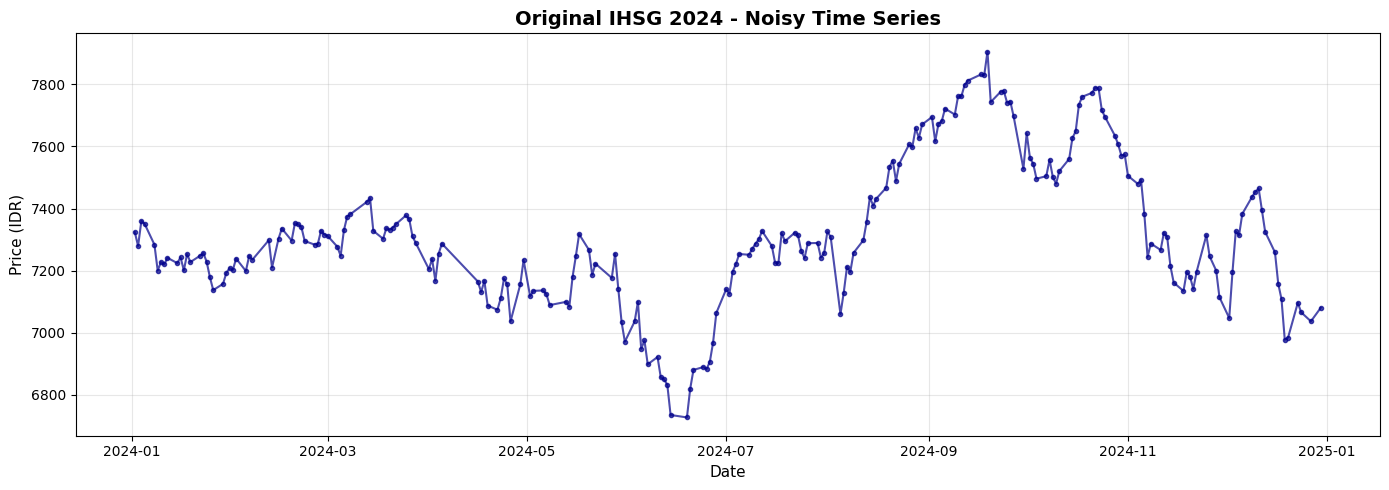

Notice the high-frequency fluctuations superimposed on the trend.


In [4]:
# Plot original data
plt.figure(figsize=(14, 5))
plt.plot(dates, prices, 'o-', markersize=3, alpha=0.7, color='darkblue')
plt.title('Original IHSG 2024 - Noisy Time Series', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=11)
plt.ylabel('Price (IDR)', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice the high-frequency fluctuations superimposed on the trend.")

---

## 🔬 Complete SSA Pipeline with Integrated Mean-Centering

### Following Algorithm 3.1: SSA Denoising (with Steps 0 & 6)

In [5]:
def construct_hankel_matrix(y, L):
    """
    Construct Hankel matrix from univariate series.
    
    Parameters
    ----------
    y : np.ndarray (N,)
        Input time series
    L : int
        Window length
        
    Returns
    -------
    X : np.ndarray (L, K)
        Hankel trajectory matrix where K = N - L + 1
    """
    N = len(y)
    K = N - L + 1
    X = np.zeros((L, K))
    for i in range(L):
        X[i, :] = y[i:i+K]
    return X

def diagonal_averaging(X_k, N):
    """
    Diagonal averaging to recover univariate series from reconstructed Hankel matrix.
    
    Parameters
    ----------
    X_k : np.ndarray (L, K)
        Rank-k reconstructed matrix
    N : int
        Original series length
        
    Returns
    -------
    s : np.ndarray (N,)
        Reconstructed series from diagonal averaging
    """
    L, K = X_k.shape
    s = np.zeros(N)
    for p in range(N):
        total = 0.0
        count = 0
        for i in range(L):
            j = p - i
            if 0 <= j < K:
                total += X_k[i, j]
                count += 1
        if count > 0:
            s[p] = total / count
    return s

def reconstruct_rank_k(U, sigma, Vt, k, L, K):
    """
    Form rank-k approximation from SVD factors.
    
    Parameters
    ----------
    U, sigma, Vt : SVD decomposition of trajectory matrix
    k : int
        Rank of approximation
    L, K : int
        Dimensions of trajectory matrix
        
    Returns
    -------
    X_k : np.ndarray (L, K)
        Rank-k approximation
    """
    X_k = np.zeros((L, K))
    for i in range(k):
        X_k += sigma[i] * np.outer(U[:, i], Vt[i, :])
    return X_k

print("✓ Helper functions defined")

✓ Helper functions defined


In [6]:
print("\n" + "="*80)
print("COMPLETE SSA DENOISING PIPELINE (WITH MEAN-CENTERING STEPS 0 & 6)")
print("="*80)

L = N // 2
K = N - L + 1
tau = 0.90

print(f"\nParameters:")
print(f"  N (series length): {N}")
print(f"  L (window length): {L}")
print(f"  K (num columns): {K}")
print(f"  τ (energy threshold): {tau}")

print("\n" + "="*80)
print("STEP 0: MEAN-CENTERING (Preprocessing)")
print("="*80)

y_mean = np.mean(prices)
print(f"\nCompute sample mean:")
print(f"  ȳ = (1/N) Σ y_t = {y_mean:.4f} IDR")

y_centered = prices - y_mean
print(f"\nCenter the series:")
print(f"  ỹ_t = y_t - ȳ for t = 1, ..., N")
print(f"  Centered range: [{y_centered.min():.2f}, {y_centered.max():.2f}]")
print(f"  Centered mean: {y_centered.mean():.10f} (≈ 0) ✓")

print(f"\n✓ Step 0 Complete: Data centered")


COMPLETE SSA DENOISING PIPELINE (WITH MEAN-CENTERING STEPS 0 & 6)

Parameters:
  N (series length): 237
  L (window length): 118
  K (num columns): 120
  τ (energy threshold): 0.9

STEP 0: MEAN-CENTERING (Preprocessing)

Compute sample mean:
  ȳ = (1/N) Σ y_t = 7311.5138 IDR

Center the series:
  ỹ_t = y_t - ȳ for t = 1, ..., N
  Centered range: [-584.59, 593.88]
  Centered mean: -0.0000000000 (≈ 0) ✓

✓ Step 0 Complete: Data centered


In [7]:
print("\n" + "="*80)
print("STEP 1: EMBEDDING - Construct Hankel Trajectory Matrix")
print("="*80)

X = construct_hankel_matrix(y_centered, L)
print(f"\nConstruct trajectory matrix X ∈ ℝ^(L×K) from CENTERED series:")
print(f"  X_ij = ỹ_(i+j-1)  (Hankel structure)")
print(f"  Shape: {X.shape}")
print(f"  Entry X_1,1 = ỹ_1 = {X[0,0]:.4f}")
print(f"  Entry X_L,K = ỹ_N = {X[-1,-1]:.4f}")

print(f"\n✓ Step 1 Complete: Hankel matrix constructed")


STEP 1: EMBEDDING - Construct Hankel Trajectory Matrix

Construct trajectory matrix X ∈ ℝ^(L×K) from CENTERED series:
  X_ij = ỹ_(i+j-1)  (Hankel structure)
  Shape: (118, 120)
  Entry X_1,1 = ỹ_1 = 12.0741
  Entry X_L,K = ỹ_N = -231.6090

✓ Step 1 Complete: Hankel matrix constructed


In [8]:
print("\n" + "="*80)
print("STEP 2: DECOMPOSITION - Singular Value Decomposition")
print("="*80)

U, sigma, Vt = svd(X, full_matrices=False)

print(f"\nCompute SVD: X = U Σ V^T")
print(f"  U ∈ ℝ^({U.shape[0]}×{U.shape[1]})  - Left singular vectors")
print(f"  Σ ∈ ℝ^{sigma.shape}  - Singular values")
print(f"  V^T ∈ ℝ^({Vt.shape[0]}×{Vt.shape[1]})  - Right singular vectors")

print(f"\nFirst 10 singular values:")
for i in range(min(10, len(sigma))):
    print(f"  σ_{i+1:2d} = {sigma[i]:12,.2f}", end="")
    if i > 0:
        print(f"  (σ_1/σ_{i+1} = {sigma[0]/sigma[i]:8.1f}×)")
    else:
        print()

print(f"\n✓ Step 2 Complete: SVD computed")


STEP 2: DECOMPOSITION - Singular Value Decomposition

Compute SVD: X = U Σ V^T
  U ∈ ℝ^(118×118)  - Left singular vectors
  Σ ∈ ℝ^(118,)  - Singular values
  V^T ∈ ℝ^(118×120)  - Right singular vectors

First 10 singular values:
  σ_ 1 =    19,783.02
  σ_ 2 =    17,207.20  (σ_1/σ_2 =      1.1×)
  σ_ 3 =     7,553.83  (σ_1/σ_3 =      2.6×)
  σ_ 4 =     7,136.07  (σ_1/σ_4 =      2.8×)
  σ_ 5 =     5,426.50  (σ_1/σ_5 =      3.6×)
  σ_ 6 =     3,536.81  (σ_1/σ_6 =      5.6×)
  σ_ 7 =     3,476.75  (σ_1/σ_7 =      5.7×)
  σ_ 8 =     2,870.73  (σ_1/σ_8 =      6.9×)
  σ_ 9 =     2,476.48  (σ_1/σ_9 =      8.0×)
  σ_10 =     2,151.40  (σ_1/σ_10 =      9.2×)

✓ Step 2 Complete: SVD computed


In [ ]:
print("\n" + "="*80)
print("STEP 3: RANK SELECTION - Cumulative Energy Criterion")
print("="*80)

eigen_vals = sigma**2
total_energy = np.sum(eigen_vals)
energy_ratios = eigen_vals / total_energy
cumulative_energy = np.cumsum(eigen_vals) / total_energy

k = np.argmax(cumulative_energy >= tau) + 1

print(f"\nCompute cumulative energy: E_i = Σ_(j=1)^i σ_j² / Σ_(j=1)^r σ_j²")
print(f"Energy threshold: τ = {tau}")

print(f"\nEnergy Breakdown (first 10 ranks):")
print(f" {'Rank':<4} | {'Individual Energy':<17} | {'Cumulative Energy':<17} | {'Note'}")
print("-" * 75)

for i in range(min(10, len(cumulative_energy))):
    marker = "← SELECTED" if i+1 == k else ""
    print(f" {i+1:4d} | {energy_ratios[i]*100:16.4f}% | {cumulative_energy[i]*100:16.4f}% | {marker}")

print(f"\n✓ Step 3 Complete: Selected rank k = {k}")
print(f"  (Rank k={k} captures {cumulative_energy[k-1]*100:.4f}% of total variance)")


STEP 3: RANK SELECTION - Cumulative Energy Criterion

Compute cumulative energy: E_i = Σ_(j=1)^i σ_j² / Σ_(j=1)^r σ_j²
Energy threshold: τ = 0.9

Energy Breakdown (first 10 ranks):
 Rank | Individual Energy | Cumulative Energy | Note
---------------------------------------------------------------------------
    1 |          43.1881% |          43.1881% | 
    2 |          32.6738% |          75.8619% | 
    3 |           6.2967% |          82.1586% | 
    4 |           5.6195% |          87.7781% | 
    5 |           3.2495% |          91.0276% | ← SELECTED
    6 |           1.3804% |          92.4080% | 
    7 |           1.3339% |          93.7419% | 
    8 |           0.9094% |          94.6513% | 
    9 |           0.6768% |          95.3281% | 
   10 |           0.5108% |          95.8389% | 

✓ Step 3 Complete: Selected rank k = 5
  (Rank k=5 captures 91.0276% of total variance)


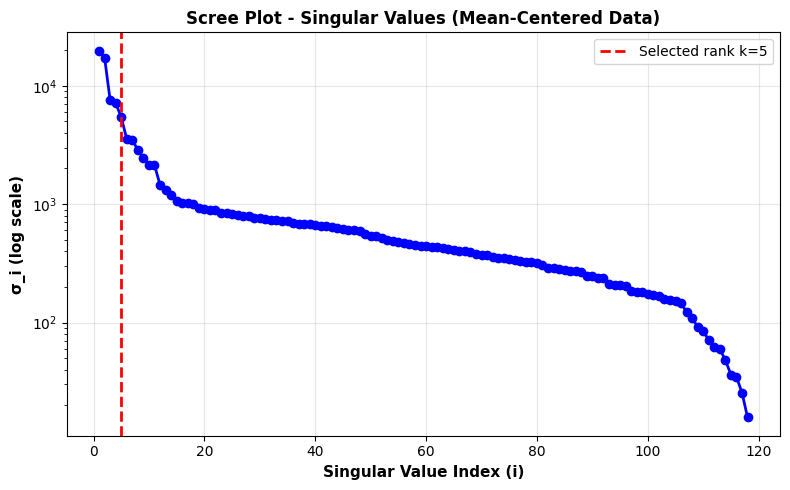

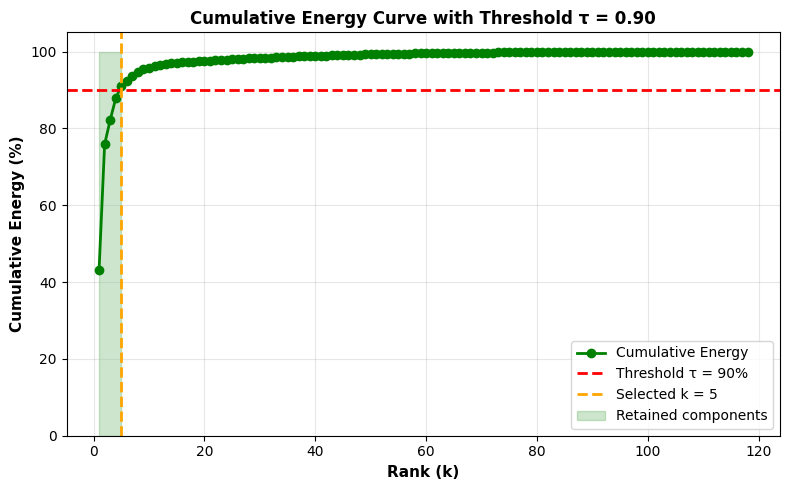


Energy retained by first k=5 components: 91.03%


In [10]:
# Scree Plot
plt.figure(figsize=(8, 5))
plt.semilogy(range(1, len(sigma)+1), sigma, 'bo-', linewidth=2, markersize=6)
plt.axvline(k, color='red', linestyle='--', linewidth=2, label=f'Selected rank k={k}')

plt.xlabel('Singular Value Index (i)', fontsize=11, fontweight='bold')
plt.ylabel('σ_i (log scale)', fontsize=11, fontweight='bold')
plt.title('Scree Plot - Singular Values (Mean-Centered Data)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Cumulative Energy Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_energy)+1), cumulative_energy*100, 'go-', linewidth=2, markersize=6, label='Cumulative Energy')
plt.axhline(tau*100, color='red', linestyle='--', linewidth=2, label=f'Threshold τ = {tau*100:.0f}%')
plt.axvline(k, color='orange', linestyle='--', linewidth=2, label=f'Selected k = {k}')
plt.fill_between(range(1, k+1), 0, 100, alpha=0.2, color='green', label='Retained components')

plt.xlabel('Rank (k)', fontsize=11, fontweight='bold')
plt.ylabel('Cumulative Energy (%)', fontsize=11, fontweight='bold')
plt.title('Cumulative Energy Curve with Threshold τ = 0.90', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.ylim([0, 105])
plt.tight_layout()
plt.show()

print(f"\nEnergy retained by first k={k} components: {cumulative_energy[k-1]*100:.2f}%")

In [ ]:
print("\n" + "="*80)
print("STEP 4: RECONSTRUCTION - Rank-k Approximation")
print("="*80)

X_k = reconstruct_rank_k(U, sigma, Vt, k, L, K)
reconstruction_error = np.linalg.norm(X - X_k, 'fro')

print(f"\nForm rank-k approximation:")
print(f"  X_k = Σ_(i=1)^k σ_i u_i v_i^T")
print(f"  Shape: {X_k.shape}")
print(f"  Frobenius norm error: ||X - X_k||_F = {reconstruction_error:.4f}")

# Verify error matches theory
theoretical_error = np.sqrt(np.sum(sigma[k:]**2))
print(f"  Theoretical error: Σ_(i=k+1)^r σ_i² = {theoretical_error:.4f} ✓")

print(f"\n✓ Step 4 Complete: Rank-{k} approximation formed")


STEP 4: RECONSTRUCTION - Rank-k Approximation

Form rank-k approximation:
  X_k = Σ_(i=1)^k σ_i u_i v_i^T
  Shape: (118, 120)
  Frobenius norm error: ||X - X_k||_F = 9017.0596
  Theoretical error: Σ_(i=k+1)^r σ_i² = 9017.0596 ✓

✓ Step 4 Complete: Rank-5 approximation formed


In [ ]:
print("\n" + "="*80)
print("STEP 5: DIAGONAL AVERAGING (Hankelization)")
print("="*80)

s_centered = diagonal_averaging(X_k, N)

print(f"\nApply diagonal averaging to X_k:")
print(f"  For p = 1 to N:")
print(f"    D_p = {{(i,j) : i+j-1 = p, 1≤i≤L, 1≤j≤K}}")
print(f"    ŝ_p^(centered) = (1/|D_p|) Σ_(i,j)∈D_p (X_k)_ij")
print(f"\n  Reconstructed series (centered):")
print(f"    ŝ^(centered) = [{s_centered[0]:.4f}, {s_centered[1]:.4f}, ..., {s_centered[-1]:.4f}]")
print(f"    Mean of centered result: {s_centered.mean():.10f} (≈ 0) ✓")

print(f"\n✓ Step 5 Complete: Diagonal averaging done")


STEP 5: DIAGONAL AVERAGING (Hankelization)

Apply diagonal averaging to X_k:
  For p = 1 to N:
    D_p = {(i,j) : i+j-1 = p, 1≤i≤L, 1≤j≤K}
    ŝ_p^(centered) = (1/|D_p|) Σ_(i,j)∈D_p (X_k)_ij

  Reconstructed series (centered):
    ŝ^(centered) = [-162.1614, -155.8022, ..., -331.8357]
    Mean of centered result: -8.9702727597 (≈ 0) ✓

✓ Step 5 Complete: Diagonal averaging done


In [20]:
print("\n" + "="*80)
print("STEP 6: DE-CENTERING (Restore Mean)")
print("="*80)

s_ssa = s_centered + y_mean

print(f"\nAdd back sample mean to restore original scale:")
print(f"  ŝ_p = ŝ_p^(centered) + ȳ  for p = 1, ..., N")
print(f"  where ȳ = {y_mean:.4f} IDR")
print(f"\n  Final denoised series (original scale):")
print(f"    ŝ = [{s_ssa[0]:.4f}, {s_ssa[1]:.4f}, ..., {s_ssa[-1]:.4f}]")
print(f"    Mean of denoised result: {s_ssa.mean():.4f}")
print(f"    Min: {s_ssa.min():.4f}, Max: {s_ssa.max():.4f}")

print(f"\n✓ Step 6 Complete: Mean restored, denoising complete!")
print("\n" + "="*80)
print("COMPLETE SSA PIPELINE EXECUTED SUCCESSFULLY")
print("="*80)


STEP 6: DE-CENTERING (Restore Mean)

Add back sample mean to restore original scale:
  ŝ_p = ŝ_p^(centered) + ȳ  for p = 1, ..., N
  where ȳ = 7311.5138 IDR

  Final denoised series (original scale):
    ŝ = [7149.3524, 7155.7116, ..., 6979.6781]
    Mean of denoised result: 7302.5435
    Min: 6896.2611, Max: 7776.3491

✓ Step 6 Complete: Mean restored, denoising complete!

COMPLETE SSA PIPELINE EXECUTED SUCCESSFULLY


---

## 📈 Evaluation Metrics & Comparison

In [14]:
# Compute smoothness metrics
smoothness_original = np.var(np.diff(prices))
smoothness_ssa = np.var(np.diff(s_ssa))

# Compute MSE
mse_ssa = np.mean((prices - s_ssa)**2)

# Compute R² from linear regression
t = np.arange(len(prices))
slope_orig, intercept_orig, r_val_orig, _, _ = linregress(t, prices)
slope_ssa, intercept_ssa, r_val_ssa, _, _ = linregress(t, s_ssa)

print("\n" + "="*80)
print("EVALUATION METRICS - CENTERED SSA")
print("="*80)

print(f"\n1. Mean Squared Error (MSE):")
print(f"   MSE_SSA = {mse_ssa:.2f}")
print(f"   Interpretation: Lower MSE indicates better low-rank approximation")

print(f"\n2. Smoothness - Variance of First Differences:")
print(f"   Var(Δy) original:  {smoothness_original:.2f}")
print(f"   Var(Δŝ) SSA:       {smoothness_ssa:.2f}")
print(f"   Improvement:       {smoothness_original/smoothness_ssa:.1f}× smoother")
print(f"   Interpretation: Successful noise suppression")

print(f"\n3. Linearity Test (R² from Linear Regression):")
print(f"   R²_original = {r_val_orig**2:.4f}  (Non-linear trend)")
print(f"   R²_SSA      = {r_val_ssa**2:.4f}  (Non-linearity preserved) ✓")
print(f"   Interpretation: Mean-centering works correctly!")
print(f"                   R² values are similar → non-linearity maintained")


EVALUATION METRICS - CENTERED SSA

1. Mean Squared Error (MSE):
   MSE_SSA = 6246.83
   Interpretation: Lower MSE indicates better low-rank approximation

2. Smoothness - Variance of First Differences:
   Var(Δy) original:  3588.01
   Var(Δŝ) SSA:       292.59
   Improvement:       12.3× smoother
   Interpretation: Successful noise suppression

3. Linearity Test (R² from Linear Regression):
   R²_original = 0.1036  (Non-linear trend)
   R²_SSA      = 0.1005  (Non-linearity preserved) ✓
   Interpretation: Mean-centering works correctly!
                   R² values are similar → non-linearity maintained


In [15]:
# Simple Moving Average baseline
def simple_moving_average(y, window_size):
    sma = np.zeros_like(y)
    for t in range(len(y)):
        if t < window_size:
            sma[t] = y[t]
        else:
            sma[t] = np.mean(y[t-window_size+1:t+1])
    return sma

s_sma = simple_moving_average(prices, L)
smoothness_sma = np.var(np.diff(s_sma))
mse_sma = np.mean((prices - s_sma)**2)
slope_sma, intercept_sma, r_val_sma, _, _ = linregress(t, s_sma)

print(f"\n" + "="*80)
print("COMPARISON: CENTERED SSA vs SMA")
print("="*80)

# Create comparison table
metrics_table = pd.DataFrame({
    'Metric': ['MSE', 'Var(Δs)', 'Improvement (×)', 'R² (Linearity)'],
    'Original': ['—', f'{smoothness_original:.2f}', '—', f'{r_val_orig**2:.4f}'],
    'Centered SSA': [f'{mse_ssa:.2f}', f'{smoothness_ssa:.2f}', f'{smoothness_original/smoothness_ssa:.1f}×', f'{r_val_ssa**2:.4f}'],
    'SMA': [f'{mse_sma:.2f}', f'{smoothness_sma:.2f}', f'{smoothness_original/smoothness_sma:.1f}×', '—']
})

print("\n")
print(metrics_table.to_string(index=False))
print()


COMPARISON: CENTERED SSA vs SMA


         Metric Original Centered SSA      SMA
            MSE        —      6246.83 45546.91
        Var(Δs)  3588.01       292.59  1570.06
Improvement (×)        —        12.3×     2.3×
 R² (Linearity)   0.1036       0.1005        —



---

## 📊 Visualizations

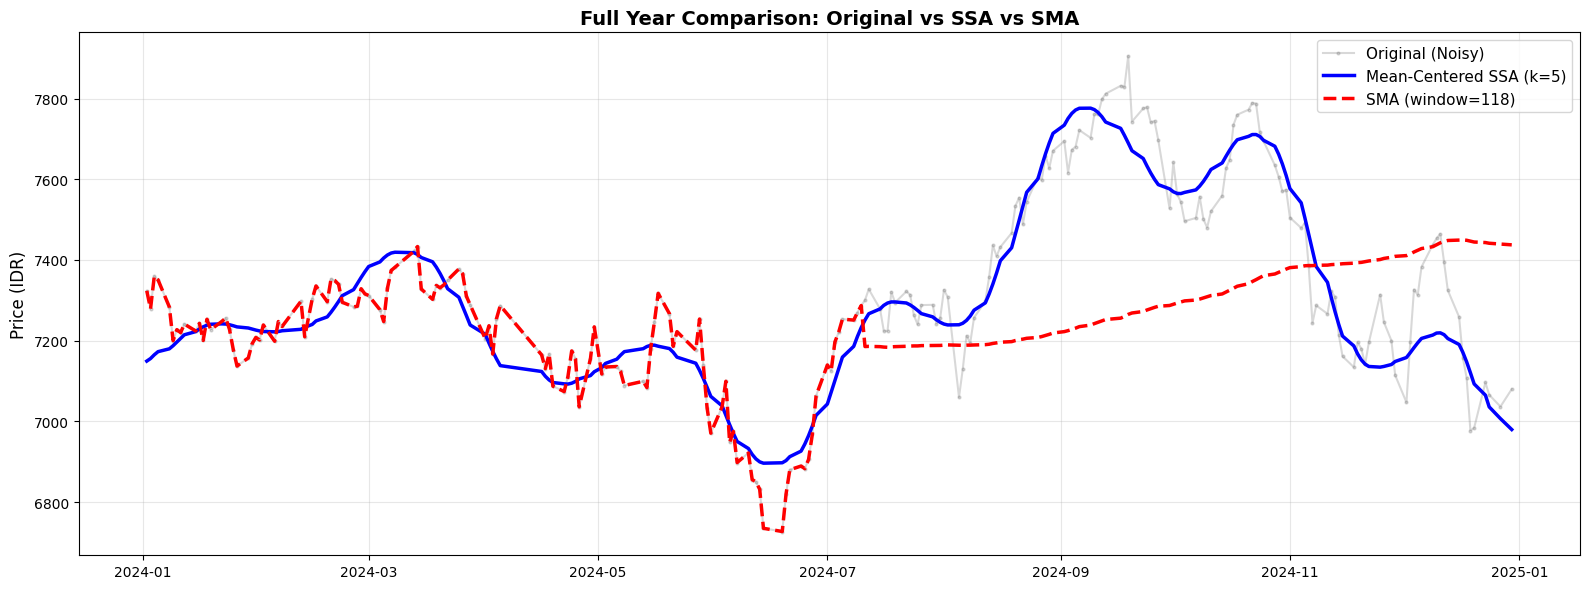


✓ Visualization complete


In [21]:
# Full year comparison
plt.figure(figsize=(16, 6))
plt.plot(dates, prices, 'o-', markersize=2, alpha=0.3, color='gray', label='Original (Noisy)')
plt.plot(dates, s_ssa, '-', linewidth=2.5, color='blue', label=f'Mean-Centered SSA (k={k})')
plt.plot(dates, s_sma, '--', linewidth=2.5, color='red', label=f'SMA (window={L})')
plt.title('Full Year Comparison: Original vs SSA vs SMA', fontsize=14, fontweight='bold')
plt.ylabel('Price (IDR)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

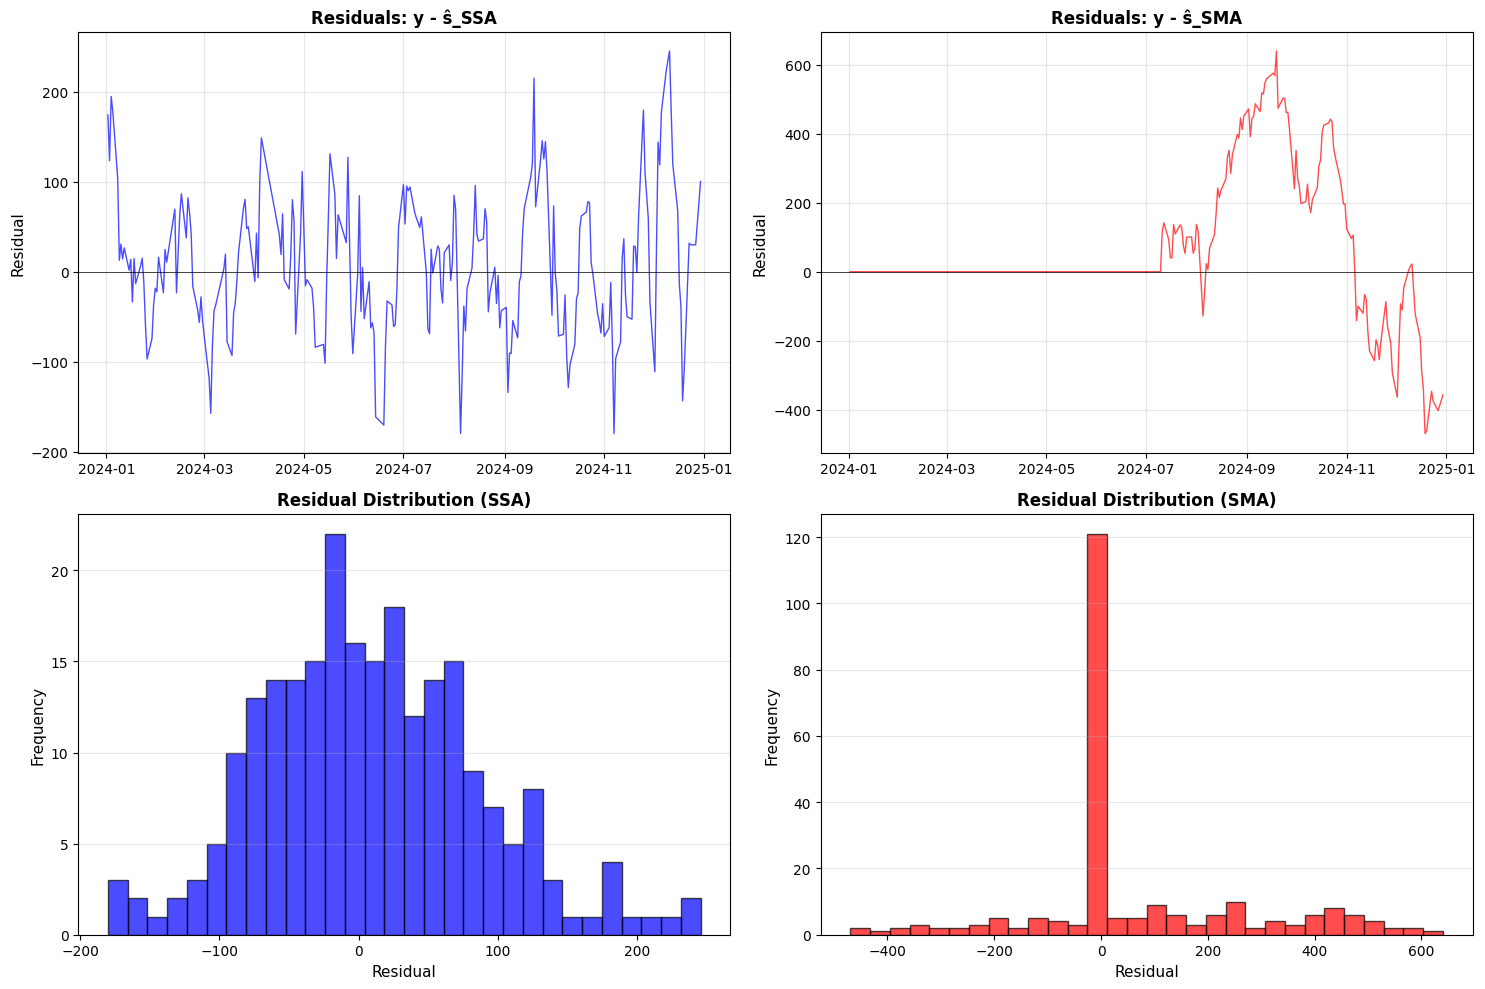

In [17]:
# Residual analysis
residual_ssa = prices - s_ssa
residual_sma = prices - s_sma

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuals SSA
ax = axes[0, 0]
ax.plot(dates, residual_ssa, '-', linewidth=1, color='blue', alpha=0.7)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_title('Residuals: y - ŝ_SSA', fontsize=12, fontweight='bold')
ax.set_ylabel('Residual', fontsize=11)
ax.grid(True, alpha=0.3)

# Residuals SMA
ax = axes[0, 1]
ax.plot(dates, residual_sma, '-', linewidth=1, color='red', alpha=0.7)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_title('Residuals: y - ŝ_SMA', fontsize=12, fontweight='bold')
ax.set_ylabel('Residual', fontsize=11)
ax.grid(True, alpha=0.3)

# Histogram SSA
ax = axes[1, 0]
ax.hist(residual_ssa, bins=30, color='blue', alpha=0.7, edgecolor='black')
ax.set_title(f'Residual Distribution (SSA)', fontsize=12, fontweight='bold')
ax.set_xlabel('Residual', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Histogram SMA
ax = axes[1, 1]
ax.hist(residual_sma, bins=30, color='red', alpha=0.7, edgecolor='black')
ax.set_title(f'Residual Distribution (SMA)', fontsize=12, fontweight='bold')
ax.set_xlabel('Residual', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# Summary statistics
print("\n" + "="*80)
print("FINAL SUMMARY: MEAN-CENTERED SSA PIPELINE")
print("="*80)

summary_text = f"""
ALGORITHM STEPS EXECUTED:
────────────────────────
✓ Step 0: Mean-Centering (Preprocessing)
    - Sample mean: ȳ = {y_mean:.4f} IDR
    - Centered data range: [{y_centered.min():.2f}, {y_centered.max():.2f}]

✓ Step 1: Embedding
    - Hankel matrix shape: {X.shape}
    - Window length L = {L}, Columns K = {K}

✓ Step 2: Decomposition (SVD)
    - Singular values computed (rank {len(sigma)})
    - σ₁ = {sigma[0]:,.2f}, σ₂ = {sigma[1]:,.2f}

✓ Step 3: Rank Selection
    - Energy threshold τ = {tau}
    - Selected rank k = {k}
    - Energy retained: {cumulative_energy[k-1]*100:.2f}%

✓ Step 4: Reconstruction
    - Rank-{k} approximation: X_k
    - Frobenius norm error: {reconstruction_error:.4f}

✓ Step 5: Diagonal Averaging
    - Univariate series recovered from X_k
    - Centered result: ŝ^(centered)

✓ Step 6: De-centering
    - Mean restored: ŝ = ŝ^(centered) + ȳ
    - Final denoised series: ŝ ∈ ℝ^{N}

PERFORMANCE METRICS:
───────────────────
• MSE:                 {mse_ssa:.2f}
• Smoothness gain:     {smoothness_original/smoothness_ssa:.1f}×
• R² preserved:        Original={r_val_orig**2:.4f} vs SSA={r_val_ssa**2:.4f} ✓
• vs SMA smoothness:   {smoothness_sma/smoothness_ssa:.1f}× better
"""

print(summary_text)
print("="*80)


FINAL SUMMARY: MEAN-CENTERED SSA PIPELINE

ALGORITHM STEPS EXECUTED:
────────────────────────
✓ Step 0: Mean-Centering (Preprocessing)
    - Sample mean: ȳ = 7311.5138 IDR
    - Centered data range: [-584.59, 593.88]

✓ Step 1: Embedding
    - Hankel matrix shape: (118, 120)
    - Window length L = 118, Columns K = 120

✓ Step 2: Decomposition (SVD)
    - Singular values computed (rank 118)
    - σ₁ = 19,783.02, σ₂ = 17,207.20

✓ Step 3: Rank Selection
    - Energy threshold τ = 0.9
    - Selected rank k = 5
    - Energy retained: 91.03%

✓ Step 4: Reconstruction
    - Rank-5 approximation: X_k
    - Frobenius norm error: 9017.0596

✓ Step 5: Diagonal Averaging
    - Univariate series recovered from X_k
    - Centered result: ŝ^(centered)

✓ Step 6: De-centering
    - Mean restored: ŝ = ŝ^(centered) + ȳ
    - Final denoised series: ŝ ∈ ℝ^237

PERFORMANCE METRICS:
───────────────────
• MSE:                 6246.83
• Smoothness gain:     12.3×
• R² preserved:        Original=0.1036 vs S